In [150]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
import numpy as np
import matplotlib.pyplot as plt

from dolfin import *

In [152]:
class ReparametrizedExpression(UserExpression):
    def __init__(self, f: Expression, phi, **kwargs):
        self.f = f
        self.phi = phi
        super().__init__(**kwargs)
        
    def eval(self, value, x):
        value[0] = self.f(self.phi(x[0]))
        
    def value_shape(self):
        return ()

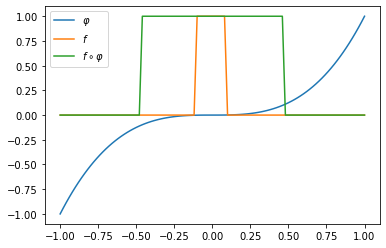

In [153]:
mesh = IntervalMesh(100, -1, 1)
f = Expression("exp(-(x[0]*x[0]/(a * a)))", degree=1, a=0.1)
f = Expression("abs(x[0]) < a ? 1 : 0", degree=0, a=0.1)
# phi = Expression("0.9 * pow(x[0],3) +  0.1 * x[0]", degree=1)
phi = Expression("pow(x[0], 3)", degree=3)
phi_inv = Expression("std::cbrt(x[0])", degree=3)
identity = Expression("x[0]", degree=1)
gphi = ReparametrizedExpression(f, phi, degree=3)


plt.figure()
plot(phi, mesh=mesh, label=r"$ \varphi$")
plot(f, mesh=mesh, label=r"$f$")
plot(gphi, mesh=mesh, label=r"$f\circ\varphi$")
plt.legend()
plt.show()

In [158]:
def solve_poisson_neumann(V, f, phi):
    # Build function space with Lagrange multiplier
    P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    R = FiniteElement("Real", mesh.ufl_cell(), 0)
    W = FunctionSpace(mesh, P1 * R)
    
    # Define variational problem
    (u, c) = TrialFunctions(W)
    (v, d) = TestFunctions(W)
    
#     phi = project(phi, W.sub(0).collapse())
    gphi = ReparametrizedExpression(f, phi, degree=3)
    
    a = (inner(grad(u), grad(v)) + c*v + u*d)*dx
    L = (Dx(phi, 0) * Dx(phi, 0)) * gphi * v * dx  + Constant(0.)*v * ds
        
    A = assemble(a)
    b = assemble(L)
        
    u = Function(W)
    solve(A, u.vector(), b)
    return u


In [159]:
f = Expression("exp(-(x[0]*x[0]/(a * a)))", degree=2, a=0.5)
f = Expression("abs(x[0]) < a ? 1 : 0", degree=0, a=0.1)

# phi = Expression("0.9 * pow(x[0], 3) +  0.1 * x[0]", degree=1)
phi = Expression("pow(x[0], 3)", degree=3)
phi_inv = Expression("std::cbrt(x[0])", degree=3)
identity = Expression("x[0]", degree=1)

mesh = IntervalMesh(100, -1, 1)
V = FunctionSpace(mesh, "CG", 1)
bcs = [DirichletBC(V, Constant(0.), "on_boundary")]

y, _ = solve_poisson_neumann(V, f, identity)
u, _ = solve_poisson_neumann(V, f, phi)
# yh = ReparametrizedExpression(u, phi_inv)

plot(u)
plot(y)
# plot(yh, mesh=mesh)
# plt.ylim(-0.1, +0.1)
plt.show()

Cannot determine geometric dimension from expression.


UFLException: Cannot determine geometric dimension from expression.

Object cannot be plotted directly, projecting to piecewise linears.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Object cannot be plotted directly, projecting to piecewise linears.


(-6.0, 6.0)

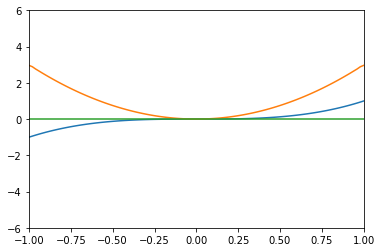

In [144]:
phi = project(phi, V)

plot(phi)
plot(Dx(phi, 0))
plot(Dx(Dx(phi, 0), 0))
plt.xlim(-1, 1)
plt.ylim(-6, 6)

In [145]:
def solve_poisson(V, f, phi, dirichlet_bcs):
    u = TrialFunction(V)
    v = TestFunction(V)
    phi = project(phi, V)
    gphi = ReparametrizedExpression(f, phi)
    a = inner(grad(u), grad(v)) * dx# - (Dx(Dx(phi, 0), 0) / Dx(phi, 0)) * u * Dx(v, 0) * dx
    L = Dx(phi, 0)**2 * gphi * v * dx
    
    
#     a = (Dx(u) * Dx(v) * dx) # - (Dx(Dx(phi)) / Dx(phi)) * Dx(u) * v) * dx
#     a = inner(grad(u), grad(v)) * dx
#     L = Dx(phi)**2 * gphi * v * dx
    
    A = assemble(a)
    b = assemble(L)
    
    for bc in dirichlet_bcs:
        bc.apply(A, b)
        
    u = Function(V)
    solve(A, u.vector(), b)
    return u
        

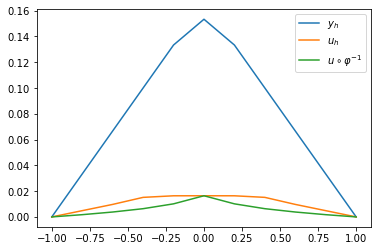

In [161]:
f = Expression("exp(-(x[0]*x[0]/(a * a)))", degree=2, a=0.2)
f = Expression("abs(x[0]) < a ? 1 : 0", degree=0, a=0.1)
phi = Expression("pow(x[0], 3)", degree=3)
phi_inv = Expression("std::cbrt(x[0])", degree=3)
identity = Expression("x[0]", degree=3)
mesh = IntervalMesh(10, -1, 1)
V = FunctionSpace(mesh, "CG", 2)
bcs = [DirichletBC(V, Constant(0.), "on_boundary")]

y = solve_poisson(V, f, identity, bcs)
u = solve_poisson(V, f, phi, [DirichletBC(V, Constant(0.), "on_boundary")])
yh = ReparametrizedExpression(u, phi_inv)

plt.figure()
plot(y, label="$y_h$")
plot(u, label="$u_h$")
plot(yh, mesh=mesh, label=r"$u\circ\varphi^{-1}$")
plt.legend()
# plt.ylim(None, 0.003)/
plt.show()

## Step Function

In [200]:
def plot_curve(f, ax=None, N=401, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(-1, 1, 401)
    return ax.plot(x, [f(xi) for xi in x], **kwargs)

AttributeError: 

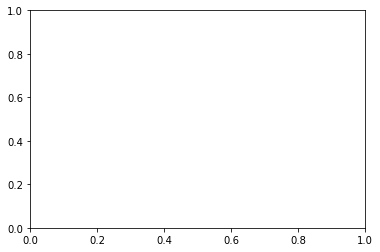

In [201]:
fig, ax = plt.subplots() #plt.figure()
plot_curve(x, phi, ax)
plt.show()

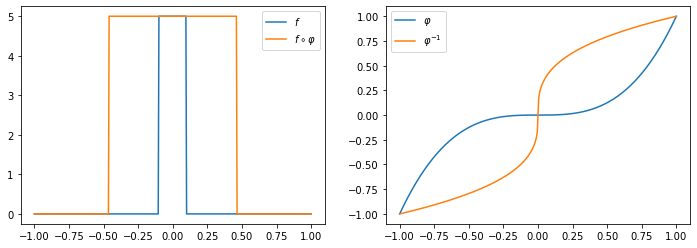

In [207]:
a = 0.1
f = Expression("abs(x[0]) <= a ? 0.5 / a : 0.", degree=0, a=a)

identity = Expression("x[0]", degree=3)
phi = Expression("pow(x[0], 3)", degree=3)
phi_inv = Expression("std::cbrt(x[0])", degree=3)
gphi = ReparametrizedExpression(f, phi, degree=3)
x = np.linspace(-1, 1, 201)
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12, 4))
plot_curve(phi, ax = ax1, label=r"$ \varphi$")
plot_curve(phi_inv, ax = ax1, label=r"$ \varphi^{-1}$")
plot_curve(f, ax=ax2, label=r"$f$")
plot_curve(gphi, ax=ax2, label=r"$f\circ\varphi$")
ax1.legend()
ax2.legend()
plt.show()

Calling FFC just-in-time (JIT) compiler, this may take some time.


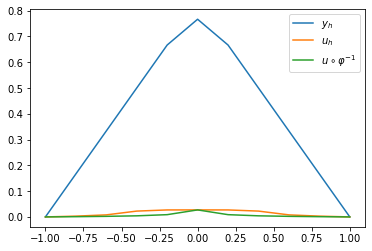

In [212]:
mesh = IntervalMesh(11, -1, 1)
mesh = IntervalMesh(10, -1, 1)
V = FunctionSpace(mesh, "CG", 2)
bcs = [DirichletBC(V, Constant(0.), "on_boundary")]

def solve_poisson(V, f, phi, dirichlet_bcs):
    u = TrialFunction(V)
    v = TestFunction(V)
    phi = project(phi, V)
    gphi = ReparametrizedExpression(f, phi)
    a = inner(grad(u), grad(v)) * dx - (Dx(Dx(phi, 0), 0) / Dx(phi, 0)) * Dx(u, 0) * v * dx
    L = Dx(phi, 0)**2 * gphi * v * dx
    
    
    A = assemble(a)
    b = assemble(L)
    
    for bc in dirichlet_bcs:
        bc.apply(A, b)
        
    u = Function(V)
    solve(A, u.vector(), b)
    return u


y = solve_poisson(V, f, identity, bcs)
u = solve_poisson(V, f, phi, [DirichletBC(V, Constant(0.), "on_boundary")])
yh = ReparametrizedExpression(u, phi_inv)

plt.figure()
plot(y, label="$y_h$")
plot(u, label="$u_h$")
plot(yh, mesh=mesh, label=r"$u\circ\varphi^{-1}$")
plt.legend()
# plt.ylim(None, 0.003)/
plt.show()